### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 6
### Due: Saturday, Apr 3rd at 11.59pm CST
---

## Problem 1

This problem has to do with density estimation and clustering. 

1. Read in `hw6_data_1.npy`. The dataset should consist of $1000$ samples with $2$ features. Note that the last column are the labels, not another feature. Make a $2$-D scatter plot of the data colored by their labels. 


2. Start with kernel density estimation on the data set. First, perform a grid search $5$-fold cross-validation to find the best bandwidth, testing $30$ bandwidths between $0.1$ and $1.0$. What is this best bandwidth? Using this best bandwidth, plot the two-dimensional kernel density estimate of the distribution. 


3. Now try a nearest neighbors approach to estimating the density. Use the Bayesian nearest neighbors option. Plot the estimated distribution. What value of $k$ neighbors do you need to make the plot look similar to your KDE distribution?


4. Now fit a Gaussian mixture model. Compute the AIC and BIC for the number of GMM components between $1$ and $10$. Plot these AIC and BIC values as a function of number of components. What is the optimal number according to the BIC? Fit the data set with this optimal number of GMM components, and create a new plot that shows the data set, the GMM component mean locations, and the $2$-sigma GMM component ellipses. *(Use the code below to help with plotting the ellipses.)*

### Solution

In [12]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from astroML.density_estimation import KNeighborsDensity
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV

(1000, 3)


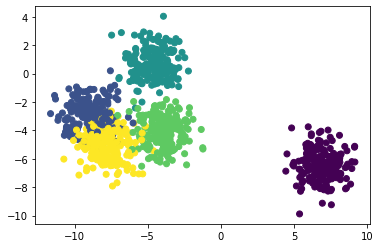

In [124]:
#1
data= np.load('../../homeworks/hw_data/hw6_data_1.npy')
print(data.shape)

x1,x2,targets= data[:,0],data[:,1],data[:,2]
plt.scatter(x1,x2,c=targets)
plt.show()

(1000, 2)
Best bandwidth = 0.4724137931034482
(10000, 2)


<ipython-input-31-a4039fde026c>:17: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  Xgrid = np.vstack(map(np.ravel, np.meshgrid(u, v))).T


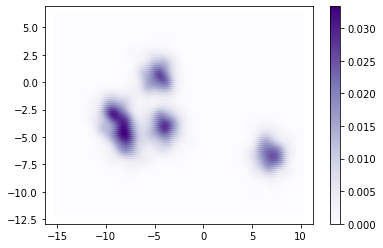

In [31]:
#2
bws= np.linspace(0.1,1,30)
K=5
print(data[:,0:2].shape)
#using the gridsearch/plot code from lecture 14
gs = GridSearchCV(KernelDensity(), {'bandwidth': bws}, cv=K) # Try each bandwidth with K-folds
gs.fit(data[:,0:2]) 
besth = gs.best_params_['bandwidth']
print('Best bandwidth = '+str(besth))
kde = KernelDensity(kernel='gaussian', bandwidth=besth)
kde.fit(data[:,0:2]) #fit the model to the data

#plotting as you did in the notebook on a more appropriate grid for this data
u= np.linspace(-15,10,100)
v= np.linspace(-12,6,100)

Xgrid = np.vstack(map(np.ravel, np.meshgrid(u, v))).T
print(Xgrid.shape)
dens_kde = np.exp(kde.score_samples(Xgrid)) #evaluate the model on the grid
plt.scatter(Xgrid[:,0], Xgrid[:,1], c=dens_kde, cmap="Purples", edgecolor="None")
plt.colorbar()

With 100 neighbors I get something pretty much resembling my KDE.


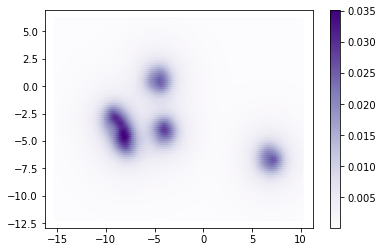

In [37]:
#3
k=100
nbs = KNeighborsDensity('bayesian', n_neighbors=k)
nbs.fit(data[:,0:2])
dens_nbs = nbs.eval(Xgrid) / 1000

plt.scatter(Xgrid[:,0], Xgrid[:,1], c=dens_nbs, cmap="Purples", edgecolor="None")
plt.colorbar()

print('With 100 neighbors I get something pretty much resembling my KDE.')

In [107]:
# Kludge to fix the bug with draw_ellipse in astroML v1.0
from matplotlib.patches import Ellipse

def draw_ellipse(mu, C, sigmas=[1, 2, 3], ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    # find principal components and rotation angle of ellipse
    sigma_x2 = C[0, 0]
    sigma_y2 = C[1, 1]
    sigma_xy = C[0, 1]

    alpha = 0.5 * np.arctan2(2 * sigma_xy,
                             (sigma_x2 - sigma_y2))
    tmp1 = 0.5 * (sigma_x2 + sigma_y2)
    tmp2 = np.sqrt(0.25 * (sigma_x2 - sigma_y2) ** 2 
                   + sigma_xy ** 2)

    sigma1 = np.sqrt(tmp1 + tmp2)
    sigma2 = np.sqrt(tmp1 - tmp2)

    for scale in sigmas:
        ax.add_patch(Ellipse((mu[0], mu[1]),
                             2 * scale * sigma1, 2 * scale * sigma2,
                             alpha * 180. / np.pi,
                             **kwargs))

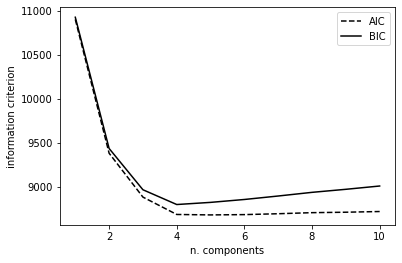

Best fit number of components as per BIC = [[4]]


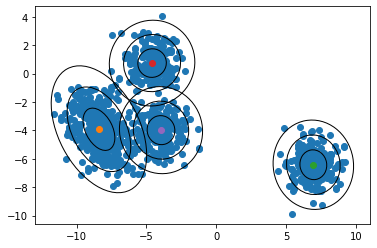

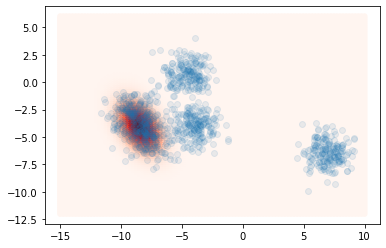

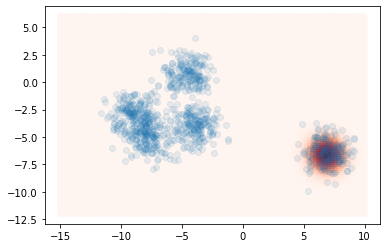

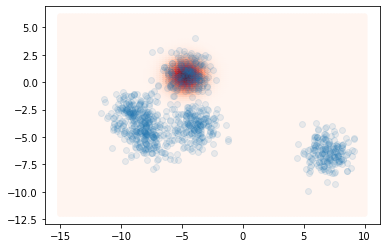

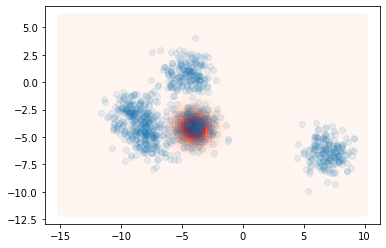

In [109]:
#4
#the same routine from the notebook for trying different numbers of components
N = np.arange(1, 11)
models = [None for i in range(len(N))]

for i in range(10):
    models[i] = GaussianMixture(N[i]).fit(data[:,0:2])

# compute the AIC and the BIC
AIC = [m.aic(data[:,0:2]) for m in models]
BIC = [m.bic(data[:,0:2]) for m in models]
bestind= np.asarray(np.where(BIC==np.amin(BIC)))
bestind = bestind.astype(np.int)

#visualizing information criteria
plt.plot(N, AIC, '--k', label='AIC')
plt.plot(N, BIC, '-k', label='BIC')
plt.xlabel('n. components')
plt.ylabel('information criterion')
plt.legend()
plt.show()

print('Best fit number of components as per BIC = ' + str(1+bestind))

#individual components
M_best = models[np.argmin(BIC)]
logprob = M_best.score_samples(Xgrid)
responsibilities = M_best.predict_proba(Xgrid)
pdf = np.exp(logprob)
pdf_individual1 = responsibilities[:,0] * pdf
pdf_individual2 = responsibilities[:,1] * pdf
pdf_individual3 = responsibilities[:,2] * pdf
pdf_individual4 = responsibilities[:,3] * pdf

draw_ellipse(M_best.means_[0,:],M_best.covariances_[0,:,:],fill=False)
draw_ellipse(M_best.means_[1,:],M_best.covariances_[1,:,:],fill=False)
draw_ellipse(M_best.means_[2,:],M_best.covariances_[2,:,:],fill=False)
draw_ellipse(M_best.means_[3,:],M_best.covariances_[3,:,:],fill=False)
plt.scatter(x1,x2)
plt.scatter(M_best.means_[0,0],M_best.means_[0,1])
plt.scatter(M_best.means_[1,0],M_best.means_[1,1])
plt.scatter(M_best.means_[2,0],M_best.means_[2,1])
plt.scatter(M_best.means_[3,0],M_best.means_[3,1])
plt.show()

#you can see them more clearly in individual plots
plt.scatter(Xgrid[:,0], Xgrid[:,1], c=pdf_individual1, cmap="Reds", edgecolor="None")
plt.scatter(x1,x2,alpha=.1)
plt.show()
plt.scatter(Xgrid[:,0], Xgrid[:,1], c=pdf_individual2, cmap="Reds", edgecolor="None")
plt.scatter(x1,x2,alpha=.1)
plt.show()
plt.scatter(Xgrid[:,0], Xgrid[:,1], c=pdf_individual3, cmap="Reds", edgecolor="None")
plt.scatter(x1,x2,alpha=.1)
plt.show()
plt.scatter(Xgrid[:,0], Xgrid[:,1], c=pdf_individual4, cmap="Reds", edgecolor="None")
plt.scatter(x1,x2,alpha=.1)
plt.show()


5. Now try Kmeans clustering with $5$ clusters. 
    - Use the `StandardScalar` to scale the data.
    - Fit the Kmeans model.
    - Find the cluster centers, and then inverse transform thse cluster centers back to the original unscaled coordinates.
    - Predict the labels for the scaled data.
    - Finally, make a two-panel side by side plot showing (a) the original data colored by its labels, then (b) the data colored by the Kmeans predicted labels, with cluster centers superposed.

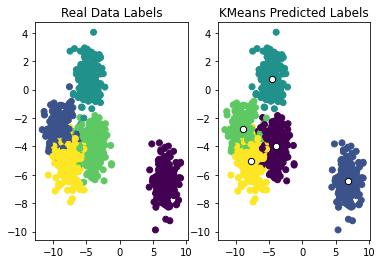

In [127]:
from sklearn import preprocessing
from sklearn.cluster import KMeans
n_clusters = 5
scaler = preprocessing.StandardScaler()
scaled= scaler.fit_transform(data)
clf = KMeans(n_clusters)
clf.fit(scaled)

centers=scaler.inverse_transform(clf.cluster_centers_)
predictions = clf.predict(scaled)

fig,(ax1,ax2) = plt.subplots(1,2)
ax1.scatter(x1,x2,c=targets)
ax1.set_title('Real Data Labels')
ax2.scatter(x1,x2,c=predictions)
ax2.set_title('KMeans Predicted Labels')
ax2.scatter(centers[:, 0], centers[:, 1],
           s=40, c='w', edgecolors='k')

plt.show()

---

## Problem 2

This problem has to do with dimensional reduction. We're going to load in a sample of SDSS Imaging data. 

1. Execute the cell below to read in the data, print out the feature names, and create a data matrix out of a subset of features.

In [128]:
from astroML.datasets import fetch_imaging_sample
data2 = fetch_imaging_sample()  
data2.shape  # number of objects in dataset

print(data2.dtype.names)

keylist = ['ra', 'dec', 'rExtSFD', 'uRaw', 
           'gRaw', 'rRaw', 'iRaw', 'zRaw', 
           'uErr', 'gErr', 'rErr', 'iErr', 
           'zErr', 'uRawPSF', 'gRawPSF', 
           'rRawPSF', 'iRawPSF', 'zRawPSF', 
           'upsfErr', 'gpsfErr', 'rpsfErr', 
           'ipsfErr', 'zpsfErr']

X = np.column_stack([data2[key] for key in keylist]) 
print(X.shape)

('ra', 'dec', 'run', 'rExtSFD', 'uRaw', 'gRaw', 'rRaw', 'iRaw', 'zRaw', 'uErr', 'gErr', 'rErr', 'iErr', 'zErr', 'uRawPSF', 'gRawPSF', 'rRawPSF', 'iRawPSF', 'zRawPSF', 'upsfErr', 'gpsfErr', 'rpsfErr', 'ipsfErr', 'zpsfErr', 'type', 'ISOLATED')
(330753, 23)


2. Use PCA (with randomized svd_solver for speed if necessary) to reduce the data matrix down to $2$ features. What is the explained variance of the data encapsulated in these eigen-features?


3. Access the `type` key of the `data` structure and make an array of labels out of these. Do some research in astroML documentation to find out what these integer types correspond to, and state that here.


4. Choose $5000$ random integers between 0 and the number of samples in the data matrix. Record these integers because you'll use them later. Make a scatter plot of the PCA-reduced data for these $5000$ random samples, colored by their corresponding `type`. *(You may want to set the transparency to be lower than 1 to see the mixing of samples.)*


5. Now try some non-linear dimensional reduction. These algorithms are slower than PCA, so you will operate only on the $5000$ random samples identified in the previous part. 
    - Try `LocallyLinearEmbedding`, `Isomap`, and `TSNE` algorithms, setting the number of components to be $2$ in all cases. 
    - As in the PCA case, make scatter plots of the dimensionally-reduced data, color coded by their `type`. For LLE and Isomap, experiment with the number of nearest neighbors between $5$ and $100$ to see what visually gives the best separation in `type` populations. For TSNE, do the same for the perplexity attribute. 
    - Which algorithm gives the cleanest way to visually see the two populations of sources? *(This will be subjective according to the samples you trained on, and even the randomness of the algorithms.)*

### Solution

In [121]:
from sklearn.decomposition import PCA
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import TSNE
from sklearn.manifold import Isomap
    

In [130]:
#2
ncomp= 2
pca = PCA(ncomp, svd_solver='randomized')
pca.fit(X)
evals = pca.explained_variance_ratio_ 
print('Expained fractional variance of data encapsulated in the eigenvalues: ' + str(np.sum(evals)))

Expained fractional variance of data encapsulated in the eigenvalues: 0.783314620395067


In [138]:
#3
labels=data2['type']
# 3 is for resolved sources and 6 is for unresolved sources

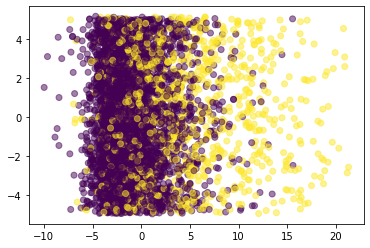

In [148]:
#4
samps= np.asarray(330753*np.random.random_sample(5000),dtype=int)
pcaplot= pca.transform(X[samps,:])
plt.scatter(pcaplot[:,0],pcaplot[:,1],c=labels[samps],alpha=0.5)
plt.show()

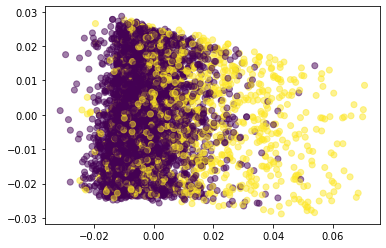

In [156]:
#5
k = 100 # Number of neighbors to use in fit
lle = LocallyLinearEmbedding(n_neighbors=k,n_components=ncomp)
lle.fit(X[samps,:])
XLLE = lle.transform(X[samps,:])
plt.scatter(XLLE[:,0], XLLE[:,1], c=labels[samps],alpha=0.5) 
plt.show()


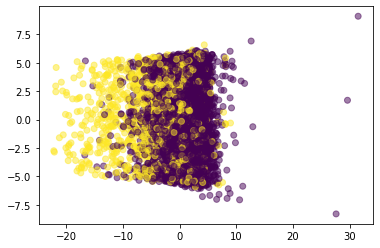

In [157]:
iso = Isomap(n_neighbors=k,n_components=ncomp)
iso.fit(X[samps,:])
XISO = iso.transform(X[samps,:])
plt.scatter(XISO[:,0], XISO[:,1], c=labels[samps],alpha=0.5) 
plt.show()

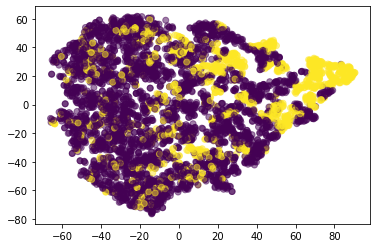

In [153]:
tsne = TSNE(n_components=ncomp,learning_rate=200)
XTSNE = tsne.fit_transform(X[samps,:])
plt.scatter(XTSNE[:,0], XTSNE[:,1], c=labels[samps],alpha=0.5) 
plt.show()

I like the way LLE separates the resolved and unresolved sources, it's hard to wrap my head around why these sources 
would be geometrically close so as to be close to one another in the LLE mapping, but it looks good to my eye.